First step is to import required libraries and utilities.

In [1]:
# -*- coding: utf-8 -*-
import json # For reading COCO annotations file
import cv2   # For image loading and manipulation
import numpy as np  # For numerical and array operations

from matplotlib import pyplot as plt   # For visualizing images

import os  # For file system access
from ultralytics import YOLO  # Model to train

### STEP I: Visualize Images

First, I set the path to the annotations file. Then I load the file using __json__ library, after which I specifically extract the specific information for the images and their respective annotations.

In [2]:
def return_split_files(split, dataset_folder = "stenosis_dataset", images = True):
    # Path to corresponding COCO annotations file
    if split == "test":
        ANN_PATH = "../extras/extra_coco_annotations.json"
    else:
        ANN_PATH = "../extras/coco_annotations.json"

    # Load annotations file
    file = json.load(open(ANN_PATH, "r"))

    ftype = "images" if images else "labels"
    
    image_base_dir = f"..datasets/{dataset_folder}/{ftype}/{split}"
    image_paths = [os.path.join(image_base_dir, f) for f in os.listdir(image_base_dir)]
    return image_paths

TEST_IMAGE_PATHS = return_split_files("test", "stenosis_dataset", True)
TEST_LABEL_PATHS = return_split_files("test", "stenosis_dataset", False)

### STEP II: Model Training

Now, I train the model. To do this, I need to ensure that the results are repproducible. I also need a configuration file telling the model where to find the data, and what labels to expect in the data.

In [3]:
import torch

In [4]:
# Ensure reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Instantiate model
model = YOLO('yolov9c.pt')

In [6]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): RepNCSPELAN4(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Sequential(
          (0): RepCSP(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              

In [7]:
# Load configuration file
CONFIG_FILE = os.path.join("..", "config", "stenosis_config.yaml")

In [8]:
# Set image size for training
ORIGINAL_IMGSZ = (694, 542)
# IMGSZ = 672
IMGSZ = 640
freeze = None
dropout = .4

In [9]:
# Folder for storing model artefacts
folder = "stenosis_yolov9c_dropout"

In [10]:
# Train model
results = model.train(
    data = CONFIG_FILE,
    visualize = True,
    epochs = 150,
    imgsz = IMGSZ,
    optimizer = "Adam",
    lr0 = 1e-3,
    batch = -1,
    pretrained = True,
    freeze = freeze,
    save = True,
    cos_lr = True,
    deterministic = True,
    dropout = dropout,
    auto_augment = "augmix",
    patience=0,
    copy_paste = 1.,
    hsv_h = .5,
    mixup = 1.,
    fliplr = 1.,
    name = folder
)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=../config/stenosis_config.yaml, epochs=150, time=None, patience=0, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=stenosis_yolov9c_dropout, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.4, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

/home/harkhymadhe/miniforge3/envs/mri/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025831482/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU) 8.00G total, 0.33G reserved, 0.24G allocated, 7.44G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    25532316       103.7         1.049         47.32         125.7        (1, 3, 640, 640)                    list
    25532316       207.4         1.726         48.82         121.9        (2, 3, 640, 640)                    list
    25532316       414.8         2.869         58.98         71.41        (4, 3, 640, 640)                    list
    25532316       829.6         5.497         103.2         111.9        (8, 3, 640, 640)                    list
    25532316        1659        10.429          2975          3083       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 6 for CUDA:0 4.75G/8.00G (59%) ✅


train: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/train.cache... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]
val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/val.cache... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<?, ?it/s]


Plotting labels to runs/detect/stenosis_yolov9c_dropout/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.000515625), 160 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/stenosis_yolov9c_dropout
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      4.54G      5.941      14.55      3.043         17        640: 100%|██████████| 11/11 [00:03<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

                   all         35        239          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      4.65G      4.185      6.437      1.924         38        640: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]

                   all         35        239          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      4.79G      2.692       3.43      1.152         15        640: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

                   all         35        239    0.00405      0.146    0.00273    0.00119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      4.79G       2.48      2.596      1.114         18        640: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

                   all         35        239    0.00919     0.0211    0.00477      0.002



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      4.79G      2.463      2.085      1.121         14        640: 100%|██████████| 11/11 [00:03<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         35        239     0.0077      0.183    0.00541    0.00204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      4.78G      2.459      2.418      1.099         41        640: 100%|██████████| 11/11 [00:02<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]

                   all         35        239    0.00574      0.203    0.00456    0.00144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      4.79G      2.575      2.393      1.124         15        640: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         35        239      0.568     0.0417     0.0283    0.00695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      4.79G      2.418      2.162      1.076         16        640: 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

                   all         35        239     0.0263      0.121     0.0189    0.00632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      4.79G      2.339      2.078      1.074         23        640: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

                   all         35        239      0.265      0.107     0.0126      0.004



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      4.79G      2.419      2.063       1.11         32        640: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

                   all         35        239     0.0173      0.154     0.0163    0.00546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150       4.8G      2.432      2.022      1.132         15        640: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.91it/s]

                   all         35        239      0.522      0.103     0.0185    0.00565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150       4.8G      2.394      1.892      1.095         28        640: 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]

                   all         35        239      0.265      0.111     0.0155    0.00436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      4.78G      2.385      1.836       1.05         52        640: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]


                   all         35        239     0.0142      0.127     0.0115    0.00345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      4.79G      2.312      1.779       1.07         29        640: 100%|██████████| 11/11 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

                   all         35        239    0.00808      0.277    0.00828    0.00269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      4.79G      2.156      1.816      1.035         26        640: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

                   all         35        239      0.514     0.0416    0.00937    0.00235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      4.79G      2.222      1.953      1.046         40        640: 100%|██████████| 11/11 [00:02<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]

                   all         35        239     0.0119      0.317     0.0106    0.00365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150       4.8G      2.172       2.14      1.027          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.56it/s]

                   all         35        239    0.00373     0.0145    0.00192    0.00039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150       4.8G      2.172      1.892      1.047         38        640: 100%|██████████| 11/11 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

                   all         35        239    0.00521     0.0442    0.00303    0.00135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      4.79G      2.233      2.059      1.048          9        640: 100%|██████████| 11/11 [00:02<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

                   all         35        239      0.262      0.076     0.0127    0.00436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      4.79G      2.157      1.772      1.017         13        640: 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]

                   all         35        239       0.52      0.161     0.0193      0.006



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      4.79G      2.204      1.798      1.084          9        640: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

                   all         35        239      0.525     0.0943     0.0196    0.00838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      4.79G      2.146      1.746     0.9946         34        640: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

                   all         35        239      0.523     0.0752     0.0191    0.00797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      4.79G      2.063      1.735     0.9933         46        640: 100%|██████████| 11/11 [00:02<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all         35        239      0.277     0.0736     0.0179    0.00708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      4.79G      2.098      1.773     0.9812          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         35        239      0.266     0.0428     0.0137    0.00587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      4.78G      2.119      1.691      1.008         17        640: 100%|██████████| 11/11 [00:02<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]

                   all         35        239      0.268     0.0679     0.0135    0.00522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      4.79G      2.068      1.714       1.02         12        640: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

                   all         35        239      0.268      0.124     0.0191    0.00812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      4.79G      2.027      1.672      1.006         28        640: 100%|██████████| 11/11 [00:02<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]

                   all         35        239      0.272      0.189     0.0236    0.00941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      4.79G      2.039      1.654      1.013         20        640: 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

                   all         35        239     0.0118      0.373     0.0224    0.00776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150       4.8G       2.06      1.587      1.002         20        640: 100%|██████████| 11/11 [00:02<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         35        239      0.011       0.32       0.02    0.00666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      4.79G      2.061      1.549     0.9839         17        640: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

                   all         35        239    0.00967      0.281     0.0168     0.0059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      4.79G      2.133      1.607      1.009          9        640: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]

                   all         35        239      0.266     0.0597     0.0164    0.00669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      4.79G      2.099      1.587      1.007         21        640: 100%|██████████| 11/11 [00:02<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.08it/s]

                   all         35        239      0.267     0.0577     0.0149    0.00651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      4.79G       2.06      1.512      0.998         19        640: 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]

                   all         35        239      0.261     0.0339    0.00994    0.00333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      4.79G      2.108      1.549     0.9948         44        640: 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]

                   all         35        239     0.0144      0.123     0.0133    0.00403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150       4.8G      2.022      1.584     0.9755         45        640: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all         35        239      0.268     0.0567     0.0166    0.00648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      4.79G      2.019      1.565      1.005         11        640: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         35        239      0.271     0.0564      0.019    0.00685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      4.79G      2.032      1.518     0.9891         22        640: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

                   all         35        239      0.267     0.0448     0.0163    0.00581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150       4.8G      2.057      1.576     0.9949         15        640: 100%|██████████| 11/11 [00:03<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all         35        239      0.265     0.0484     0.0163      0.005



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      4.79G      1.892      1.474     0.9474         26        640: 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         35        239      0.262     0.0599     0.0179    0.00624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      4.79G      2.008      1.504     0.9884         41        640: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

                   all         35        239      0.269      0.132     0.0196    0.00755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      4.79G      2.014       1.46     0.9701         36        640: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         35        239      0.267     0.0848     0.0185    0.00655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      4.79G      1.938      1.462     0.9561         16        640: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

                   all         35        239      0.266     0.0972     0.0164    0.00494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      4.78G      1.865      1.456     0.9454         10        640: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         35        239      0.263     0.0748     0.0141    0.00473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      4.79G      1.938      1.466     0.9855          8        640: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.08it/s]

                   all         35        239      0.263     0.0594     0.0137    0.00525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      4.79G      1.954      1.449      0.973         30        640: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

                   all         35        239      0.263     0.0442     0.0132    0.00472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150       4.8G      1.984      1.428     0.9723         19        640: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

                   all         35        239      0.264     0.0416     0.0118    0.00476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150       4.8G       1.89      1.382     0.9638         24        640: 100%|██████████| 11/11 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.81it/s]

                   all         35        239      0.261      0.025    0.00595    0.00199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150       4.8G      1.877      1.391     0.9684         22        640: 100%|██████████| 11/11 [00:02<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

                   all         35        239      0.259     0.0286    0.00468    0.00156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150       4.8G      1.882      1.347     0.9528         21        640: 100%|██████████| 11/11 [00:02<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         35        239      0.266     0.0419    0.00792    0.00279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150       4.8G      1.939       1.36     0.9521         16        640: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all         35        239      0.272     0.0584     0.0107     0.0036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150       4.8G      1.929      1.399     0.9828         20        640: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all         35        239       0.27     0.0564     0.0124    0.00424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      4.79G      1.961      1.385     0.9407         32        640: 100%|██████████| 11/11 [00:02<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.08it/s]

                   all         35        239       0.27      0.063     0.0136     0.0045



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150       4.8G      1.947      1.408     0.9725         13        640: 100%|██████████| 11/11 [00:02<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         35        239      0.273     0.0749     0.0133    0.00451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      4.79G      1.968      1.455     0.9759         10        640: 100%|██████████| 11/11 [00:02<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         35        239      0.275     0.0822      0.014    0.00508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150       4.8G      1.851      1.341     0.9448         16        640: 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


                   all         35        239       0.28     0.0921     0.0191    0.00648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      4.79G       1.89      1.307     0.9435         32        640: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

                   all         35        239      0.287     0.0842      0.019    0.00654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      4.78G      1.886      1.354     0.9657         14        640: 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

                   all         35        239      0.282     0.0717     0.0197    0.00676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      4.79G      1.832      1.337     0.9586         24        640: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         35        239      0.281      0.065     0.0185    0.00597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      4.79G      1.828      1.311       0.96         19        640: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         35        239      0.278     0.0555     0.0205    0.00634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      4.79G      1.732      1.266     0.9299         23        640: 100%|██████████| 11/11 [00:02<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         35        239      0.284     0.0581     0.0227    0.00737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150       4.8G      1.829      1.278     0.9278         38        640: 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

                   all         35        239      0.281     0.0433     0.0249    0.00761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      4.78G      1.829      1.297     0.9464         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

                   all         35        239      0.571     0.0357     0.0302    0.00881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150       4.8G      1.792        1.3     0.9553         18        640: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

                   all         35        239      0.545     0.0433      0.026    0.00878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      4.79G      1.783      1.249     0.9431         30        640: 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

                   all         35        239      0.545      0.036     0.0266    0.00818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150       4.8G      1.792      1.214     0.9223         24        640: 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]

                   all         35        239       0.31     0.0485     0.0289    0.00821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150       4.8G      1.728      1.206     0.9332         49        640: 100%|██████████| 11/11 [00:02<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]

                   all         35        239      0.316     0.0558     0.0328    0.00912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150       4.8G      1.731      1.264     0.9418          6        640: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.91it/s]

                   all         35        239       0.57     0.0561     0.0344    0.00938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      4.79G      1.728      1.218     0.9282         35        640: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         35        239      0.557     0.0527     0.0301    0.00837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      4.79G      1.704       1.26     0.9171         18        640: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

                   all         35        239      0.557      0.067      0.033    0.00887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      4.79G      1.787      1.306     0.9402         18        640: 100%|██████████| 11/11 [00:02<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.95it/s]

                   all         35        239      0.559     0.0839     0.0343    0.00989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150       4.8G      1.707      1.231     0.9243         17        640: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]

                   all         35        239      0.558     0.0836      0.035     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      4.79G      1.786      1.259     0.9501         32        640: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.78it/s]

                   all         35        239      0.556     0.0908     0.0334     0.0102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      4.79G      1.693      1.208     0.9291         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         35        239      0.561     0.0894      0.032    0.00976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150       4.8G      1.728      1.202     0.9326         14        640: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.82it/s]

                   all         35        239      0.559     0.0851     0.0295    0.00947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      4.79G      1.681      1.165     0.9161         28        640: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         35        239      0.554     0.0752     0.0273    0.00931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      4.79G      1.716      1.171     0.9299         11        640: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         35        239      0.548     0.0732     0.0262    0.00869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150       4.8G      1.744       1.21     0.9345         32        640: 100%|██████████| 11/11 [00:02<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         35        239      0.561     0.0604      0.028    0.00872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      4.79G      1.696      1.232     0.9347         20        640: 100%|██████████| 11/11 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         35        239      0.546     0.0578     0.0245    0.00904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      4.79G      1.775      1.243     0.9457         19        640: 100%|██████████| 11/11 [00:02<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

                   all         35        239      0.548     0.0654     0.0267    0.00884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150       4.8G      1.631      1.144     0.9102         22        640: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         35        239      0.545     0.0578     0.0263    0.00833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      4.79G       1.66       1.13     0.9286         29        640: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]

                   all         35        239      0.542     0.0739     0.0244    0.00802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      4.79G      1.734      1.214     0.9331         49        640: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all         35        239      0.547     0.0515     0.0228    0.00787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      4.79G       1.68      1.153     0.9293         13        640: 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

                   all         35        239      0.555     0.0515      0.022    0.00758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150       4.8G      1.602       1.05     0.8998         31        640: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all         35        239      0.308     0.0518     0.0208    0.00711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      4.79G      1.566      1.071     0.8906         26        640: 100%|██████████| 11/11 [00:02<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

                   all         35        239      0.291      0.057     0.0201    0.00694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      4.79G      1.584      1.127      0.908         16        640: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]

                   all         35        239      0.296     0.0594     0.0199    0.00692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      4.79G      1.623      1.095     0.9149         20        640: 100%|██████████| 11/11 [00:02<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

                   all         35        239      0.296      0.059     0.0216    0.00744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150       4.8G       1.64      1.088     0.9211         16        640: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

                   all         35        239        0.3     0.0637     0.0224    0.00752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150       4.8G      1.592      1.091     0.9144         18        640: 100%|██████████| 11/11 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]

                   all         35        239      0.302      0.066     0.0239    0.00766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150       4.8G      1.643      1.102     0.9197         16        640: 100%|██████████| 11/11 [00:02<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]

                   all         35        239      0.305     0.0683     0.0241    0.00804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150       4.8G      1.665      1.185     0.9495          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

                   all         35        239        0.3     0.0581     0.0264    0.00863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      4.79G      1.566      1.092     0.9229         15        640: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all         35        239      0.296     0.0582     0.0262    0.00887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150       4.8G      1.635      1.108     0.9373         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

                   all         35        239      0.303     0.0544     0.0269    0.00932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      4.79G      1.669      1.065     0.9139         33        640: 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]

                   all         35        239      0.306     0.0529     0.0274    0.00953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150       4.8G      1.591      1.073     0.9211         17        640: 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

                   all         35        239      0.304     0.0511     0.0269    0.00898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150       4.8G      1.576      1.053     0.8985         27        640: 100%|██████████| 11/11 [00:02<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.81it/s]

                   all         35        239      0.286     0.0752     0.0247    0.00816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      4.79G      1.559      1.048     0.9008         16        640: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

                   all         35        239     0.0344     0.0904     0.0253    0.00829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      4.79G      1.513      1.019     0.8864         13        640: 100%|██████████| 11/11 [00:02<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

                   all         35        239      0.296     0.0564     0.0265    0.00902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      4.79G      1.585      1.138     0.9029         22        640: 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         35        239      0.294     0.0567     0.0274    0.00932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      4.79G      1.572       1.08     0.9006         13        640: 100%|██████████| 11/11 [00:02<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all         35        239      0.301     0.0544     0.0279    0.00932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      4.79G      1.508      1.048     0.8897         18        640: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]

                   all         35        239      0.293      0.064     0.0278    0.00941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      4.78G      1.536      1.105     0.8891          8        640: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]

                   all         35        239      0.291     0.0587     0.0273    0.00922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      4.79G      1.555      1.088     0.8994         24        640: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

                   all         35        239      0.296      0.066     0.0294    0.00957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      4.79G      1.488      0.991     0.9003         22        640: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         35        239      0.301     0.0729     0.0308    0.00951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      4.79G      1.512      1.037     0.8972         29        640: 100%|██████████| 11/11 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

                   all         35        239      0.305     0.0871     0.0315    0.00988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      4.78G      1.502      1.004     0.8898         17        640: 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         35        239      0.556     0.0769      0.034     0.0102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      4.78G      1.433     0.9899     0.8901         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         35        239      0.556     0.0723     0.0313    0.00964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      4.79G      1.506      1.015     0.8928          5        640: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all         35        239      0.553     0.0888     0.0321    0.00991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      4.79G      1.524      1.032     0.8972          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         35        239      0.558     0.0796      0.033    0.00962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150       4.8G      1.453      0.961     0.8828         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

                   all         35        239       0.56     0.0868     0.0347     0.0102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      4.79G      1.513      1.025     0.8934         18        640: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

                   all         35        239      0.557     0.0887     0.0333     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      4.78G      1.505     0.9891     0.8921         34        640: 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         35        239      0.304     0.0888     0.0321     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      4.78G      1.417     0.9696     0.8885         24        640: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         35        239      0.304     0.0958     0.0314     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      4.79G      1.497      1.015     0.8993         14        640: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all         35        239      0.302     0.0882     0.0311     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      4.78G      1.483      1.003     0.8967         54        640: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

                   all         35        239      0.299     0.0905     0.0315    0.00971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      4.79G       1.49     0.9911     0.8922         20        640: 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]

                   all         35        239        0.3     0.0826       0.03    0.00975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      4.79G      1.425     0.9511     0.8859         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]

                   all         35        239      0.299      0.078       0.03    0.00961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      4.79G      1.434      0.943     0.8863         21        640: 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]

                   all         35        239      0.303     0.0809     0.0298    0.00945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      4.79G      1.441     0.9733     0.8991         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

                   all         35        239      0.302     0.0789     0.0298    0.00976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      4.79G      1.428     0.9407     0.8871          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         35        239      0.299     0.0836     0.0291    0.00974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      4.79G      1.391     0.9095     0.8518         17        640: 100%|██████████| 11/11 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.86it/s]

                   all         35        239      0.296     0.0766     0.0301    0.00997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      4.79G       1.43     0.9376      0.889         14        640: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         35        239      0.298     0.0743     0.0317    0.00992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      4.79G      1.428     0.9359     0.8959         36        640: 100%|██████████| 11/11 [00:02<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         35        239       0.31     0.0664     0.0312    0.00954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      4.79G      1.415     0.9321     0.8842         31        640: 100%|██████████| 11/11 [00:02<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

                   all         35        239      0.311     0.0697     0.0316     0.0098



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      4.79G       1.37     0.9165     0.8826         14        640: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]

                   all         35        239      0.298      0.074     0.0313    0.00989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      4.78G      1.485     0.9611     0.8922         16        640: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all         35        239      0.297      0.074      0.029       0.01



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      4.78G      1.393      0.922      0.876         42        640: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         35        239      0.299     0.0786     0.0287       0.01



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      4.79G      1.389     0.9146     0.8716         29        640: 100%|██████████| 11/11 [00:02<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         35        239      0.293     0.0752     0.0289    0.00993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      4.78G      1.416     0.9697     0.9009         13        640: 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

                   all         35        239      0.292     0.0733     0.0284    0.00976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150       4.8G      1.392     0.9426     0.8622         28        640: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.73it/s]

                   all         35        239      0.292     0.0733     0.0276    0.00954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      4.79G      1.326     0.8598     0.8865          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

                   all         35        239      0.291      0.071     0.0276    0.00914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150       4.8G      1.358     0.8982     0.8577         35        640: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]

                   all         35        239      0.291     0.0707     0.0291    0.00948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      4.78G      1.375      0.909     0.8806         11        640: 100%|██████████| 11/11 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all         35        239      0.294      0.073     0.0313    0.00975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150       4.8G      1.396     0.9028      0.881         24        640: 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         35        239      0.294      0.073      0.031    0.00941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      4.79G      1.434     0.9055     0.9073         15        640: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]

                   all         35        239      0.296      0.073     0.0303    0.00928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      4.79G      1.367     0.9174     0.8583         36        640: 100%|██████████| 11/11 [00:03<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

                   all         35        239      0.293      0.074     0.0308    0.00936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      4.79G      1.321     0.8677     0.8682         38        640: 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         35        239      0.292     0.0753     0.0297    0.00934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      4.79G      1.246     0.8559     0.8682          5        640: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         35        239       0.29     0.0707     0.0274      0.009



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      4.79G      1.386     0.9227      0.875         14        640: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all         35        239      0.289     0.0684     0.0266    0.00879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150       4.8G      1.346     0.8739     0.8886         29        640: 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]

                   all         35        239      0.297     0.0757     0.0293     0.0089


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      4.79G      1.245     0.8893     0.8638          6        640: 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.78it/s]

                   all         35        239      0.291     0.0591     0.0257    0.00825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      4.79G      1.256     0.9515     0.8677          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.86it/s]

                   all         35        239      0.281      0.076     0.0213      0.007



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150       4.8G      1.226      0.927     0.8631          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         35        239      0.292     0.0472     0.0226    0.00699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      4.79G      1.196     0.9789     0.8765          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         35        239      0.283     0.0865     0.0207    0.00634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150       4.8G      1.231      0.904     0.8775          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

                   all         35        239      0.279     0.0845     0.0195    0.00609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      4.79G      1.136     0.8178     0.8576          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


                   all         35        239      0.278     0.0819       0.02    0.00594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      4.79G      1.111     0.8318     0.8547          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         35        239      0.544     0.0423     0.0207    0.00599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      4.79G      1.179     0.8565     0.8722          8        640: 100%|██████████| 11/11 [00:02<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

                   all         35        239      0.546     0.0423     0.0204    0.00613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      4.78G      1.168     0.8408     0.8569          7        640: 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

                   all         35        239      0.545     0.0423     0.0208    0.00623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      4.79G      1.156     0.8501     0.8537          6        640: 100%|██████████| 11/11 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         35        239      0.547     0.0423     0.0211    0.00624



150 epochs completed in 0.204 hours.
Optimizer stripped from runs/detect/stenosis_yolov9c_dropout/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/stenosis_yolov9c_dropout/weights/best.pt, 51.6MB

Validating runs/detect/stenosis_yolov9c_dropout/weights/best.pt...
Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
YOLOv9c summary (fused): 384 layers, 25322332 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


                   all         35        239      0.559     0.0836      0.035     0.0103
      Grade 0 Stenosis         35         12          1          0          0          0
      Grade 1 Stenosis         35         24          1          0    0.00808    0.00234
      Grade 2 Stenosis         35         95     0.0582     0.0842     0.0268     0.0097
      Grade 3 Stenosis         35        108      0.176       0.25      0.105     0.0293
Speed: 0.7ms preprocess, 15.3ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/detect/stenosis_yolov9c_dropout


In [11]:
results

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fecaeeaa310>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [12]:
def return_split_files(split, dataset_folder = "dataset", images = True):
    # Path to corresponding COCO annotations file
    if split == "test":
        ANN_PATH = "../extras/extra_coco_annotations.json"
    else:
        ANN_PATH = "../extras/coco_annotations.json"

    # Load annotations file
    file = json.load(open(ANN_PATH, "r"))

    ftype = "images" if images else "labels"
    
    image_base_dir = f"../datasets/{dataset_folder}/{ftype}/{split}"
    image_paths = [os.path.join(image_base_dir, f) for f in os.listdir(image_base_dir)]
    return image_paths

In [13]:
TRAIN_IMAGE_PATHS = return_split_files("train", "stenosis_dataset", True)
TRAIN_LABEL_PATHS = return_split_files("train", "stenosis_dataset", False)

In [14]:
VAL_IMAGE_PATHS = return_split_files("val", "stenosis_dataset", True)
VAL_LABEL_PATHS = return_split_files("val", "stenosis_dataset", False)

In [15]:
TEST_IMAGE_PATHS = return_split_files("test", "stenosis_dataset", True)
TEST_LABEL_PATHS = return_split_files("test", "stenosis_dataset", False)

---

Now we test and evaluate the model.

In [16]:
del model

In [17]:
import gc
gc.collect()

63370

In [18]:
# Load trained modoel
model = YOLO("runs/detect/stenosis_yolov9c_dropout/weights/best.pt")

In [19]:
model.val(split = "train", name = folder)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
YOLOv9c summary (fused): 384 layers, 25322332 parameters, 0 gradients, 102.3 GFLOPs


val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/train.cache... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


                   all         61        412      0.561      0.108     0.0407     0.0126
      Grade 0 Stenosis         61         26          1          0          0          0
      Grade 1 Stenosis         61         31          1          0          0          0
      Grade 2 Stenosis         61        207      0.116      0.135     0.0628     0.0206
      Grade 3 Stenosis         61        148      0.129      0.297        0.1     0.0299
Speed: 0.7ms preprocess, 24.7ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/stenosis_yolov9c_dropout2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fecaf05af40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [20]:
model.val(split = "val", name = folder)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)


val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/val.cache... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


                   all         35        239       0.56       0.09     0.0352     0.0104
      Grade 0 Stenosis         35         12          1          0          0          0
      Grade 1 Stenosis         35         24          1          0    0.00739    0.00217
      Grade 2 Stenosis         35         95     0.0601     0.0916     0.0273     0.0101
      Grade 3 Stenosis         35        108       0.18      0.269      0.106     0.0295
Speed: 0.4ms preprocess, 26.9ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/stenosis_yolov9c_dropout3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fecace360d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [21]:
model.val(split = "test", name = folder)

Ultralytics YOLOv8.2.0 🚀 Python-3.9.18 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)


val: Scanning /mnt/c/Users/Harkhymadhe/Desktop/source/export_3/SpineMRI/datasets/stenosis_dataset/labels/test.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


                   all         38        234      0.539     0.0392     0.0208     0.0077
      Grade 0 Stenosis         38         20          1          0          0          0
      Grade 1 Stenosis         38          4          1          0          0          0
      Grade 2 Stenosis         38         98     0.0349     0.0408     0.0313     0.0168
      Grade 3 Stenosis         38        112      0.122      0.116     0.0521      0.014
Speed: 1.4ms preprocess, 37.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/stenosis_yolov9c_dropout4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7febf7707d30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

---

Now we test the model to visualize predictions.

In [22]:
conf = .25

In [23]:
PREDS = model.predict(
    TRAIN_IMAGE_PATHS,
    imgsz = 640,
    conf = conf,
    iou = .8,
    show_boxes = False,
    augment = True
)

0: 512x640 9 Grade 3 Stenosiss, 80.3ms
1: 512x640 11 Grade 3 Stenosiss, 80.3ms
2: 512x640 11 Grade 3 Stenosiss, 80.3ms
3: 512x640 8 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 80.3ms
4: 512x640 7 Grade 2 Stenosiss, 80.3ms
5: 512x640 7 Grade 2 Stenosiss, 80.3ms
6: 512x640 6 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 80.3ms
7: 512x640 4 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 80.3ms
8: 512x640 5 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 80.3ms
9: 512x640 5 Grade 2 Stenosiss, 2 Grade 3 Stenosiss, 80.3ms
10: 512x640 6 Grade 2 Stenosiss, 4 Grade 3 Stenosiss, 80.3ms
11: 512x640 5 Grade 2 Stenosiss, 5 Grade 3 Stenosiss, 80.3ms
12: 512x640 1 Grade 2 Stenosis, 13 Grade 3 Stenosiss, 80.3ms
13: 512x640 7 Grade 2 Stenosiss, 80.3ms
14: 512x640 7 Grade 2 Stenosiss, 80.3ms
15: 512x640 7 Grade 2 Stenosiss, 80.3ms
16: 512x640 6 Grade 2 Stenosiss, 2 Grade 3 Stenosiss, 80.3ms
17: 512x640 3 Grade 2 Stenosiss, 3 Grade 3 Stenosiss, 80.3ms
18: 512x640 8 Grade 2 Stenosiss, 1 Grade 3 Stenosis, 80.3ms
19: 512x640 4 Grade 2 

In [24]:
pred_masks = [mask.boxes.cpu().data.numpy() for mask in PREDS]

In [25]:
pred_masks[0]

array([[     397.24,       253.1,      425.49,      270.17,      0.7683,           3],
       [     395.96,      282.78,      424.87,      302.38,      0.7147,           3],
       [     395.44,      318.65,      425.88,      333.48,     0.67086,           3],
       [     401.77,      350.57,      434.64,      363.54,     0.60047,           3],
       [     398.04,      219.82,      429.18,       234.1,      0.5288,           3],
       [     396.33,      313.02,      425.83,      330.28,     0.42214,           3],
       [     396.53,      267.36,      426.08,      288.49,     0.41007,           3],
       [     396.11,      270.72,      425.53,      290.82,     0.33831,           3],
       [     396.55,      317.66,      425.94,      336.92,     0.29095,           3]], dtype=float32)

In [26]:
PREDS[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([3., 3., 3., 3., 3., 3., 3., 3., 3.], device='cuda:0')
conf: tensor([0.7683, 0.7147, 0.6709, 0.6005, 0.5288, 0.4221, 0.4101, 0.3383, 0.2910], device='cuda:0')
data: tensor([[3.9724e+02, 2.5310e+02, 4.2549e+02, 2.7017e+02, 7.6830e-01, 3.0000e+00],
        [3.9596e+02, 2.8278e+02, 4.2487e+02, 3.0238e+02, 7.1470e-01, 3.0000e+00],
        [3.9544e+02, 3.1865e+02, 4.2588e+02, 3.3348e+02, 6.7086e-01, 3.0000e+00],
        [4.0177e+02, 3.5057e+02, 4.3464e+02, 3.6354e+02, 6.0047e-01, 3.0000e+00],
        [3.9804e+02, 2.1982e+02, 4.2918e+02, 2.3410e+02, 5.2880e-01, 3.0000e+00],
        [3.9633e+02, 3.1302e+02, 4.2583e+02, 3.3028e+02, 4.2214e-01, 3.0000e+00],
        [3.9653e+02, 2.6736e+02, 4.2608e+02, 2.8849e+02, 4.1007e-01, 3.0000e+00],
        [3.9611e+02, 2.7072e+02, 4.2553e+02, 2.9082e+02, 3.3831e-01, 3.0000e+00],
        [3.9655e+02, 3.1766e+02, 4.2594e+02, 3.3692e+02, 2.9095e-01, 3.0000e+00]], device='cuda:0')
id: None


In [27]:
b = PREDS[0]

In [28]:
b.boxes.xyxy.shape[0]

9

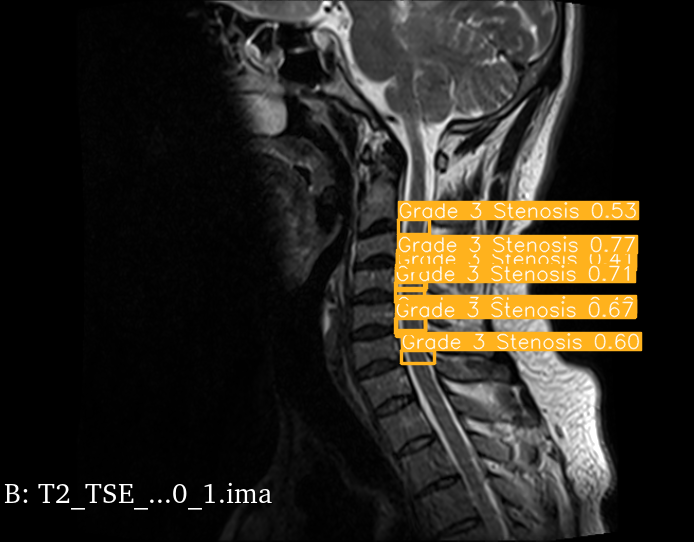

In [29]:
im = b.show()

In [30]:
im